In [46]:
import json
from collections import namedtuple
from math import radians, cos, sin, asin, sqrt
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
import pymysql
import datetime
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

# Exploring Airbnb User Experience and Characteristics In Different Cities

### 1. Introduction
In this project, we compared Airbnb user experience directly reflected by their reviews toward their stays in particular city. We first calculated sentiment score for each piece of review to measure the user experience, and used hypothesis test to compare the mean of sentiment score among different cities to see whether one city has higher user experience (i.e., higher sentiment score) than others in general. 

For each selected city, we also tried to portrait the characteristics and behaviors of the reviewers using stats fact of sampled reviewers data, explores similarities and differences between user behaviors of groups using kmeans, and finally draw our findings and conclusions.

Note: In this project, we define users as the visitors or guests who have traveled to the selected city, host excluded.

### 2. Data preparation
We obtained raw review data for three cities, New York City, Los Angeles and Boston from Airbnb open source data. Based on the valid user IDs from the dataset, we used crawlers to get more detailed reviewer information. Finally we collected data as follows:  

| Dataset        | Size    | Description                                             |
|----------------|---------|---------------------------------------------------------|
| Boston_reviews | 68,275  | Detailed Review Data for listings in Boston             |
| NYC_reviews    | 574,777 | Detailed Review Data for listings in New York City      |
| LA_reviews     | 439,414 | Detailed Review Data for listings in Los Angelas        |
| Boston_users   | 27,518  | Detailed user information of sampled visitors in Boston |
| NYC_users      | 29,750  | Detailed user information of sampled visitors in NYC    |
| LA_users       | 39,594  | Detailed user information of sampled visitors in LA     |

### 3. Data cleaning and processing
For user data of each city, we cleaned and organized them into new fields as follows:

|field |description|
|----- |-----------|
|from_country|the country this user comes from|
|visit_city| the city this users visits|
|latitude|latitude of the city this user comes from|
|longtitude|longtitude of the city this user comes from|
|distance| the distance from the city this users comes from and to 
|#trips|the number of trips this user travelled
|work|work title of this user|
|school|school of this user|
|#feedbk| the number of feedback this users sent out
|about| the about content on the user's home page
|create_time| the account create time of this user|
|sentiment_score| the sentiment score of this user's reviews|

Note: in sentiment_score, we only keep the engligh-speaking users.

### 4. Exploration and Analysis: 

### 4.1 Users Experience Comparison
We first want to see what's the high frequency words in the reviews, to do this in a convenient way, we ploted wordcloud from the reviews for each city, notice here we added few stop words which is not informative to us, words like "great", "place" and so on, where all three cities have in common.

24148755
229789074
150139131


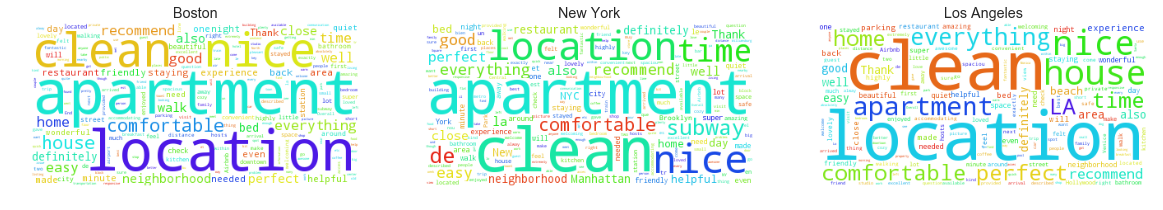

In [168]:
%matplotlib inline
plt.style.use("ggplot")
def create_wordcloud(file,title):
    words = open(file).read()
    print len(words)
    stopwords = set(STOPWORDS)
    stopwords.add("great")
    stopwords.add("place")
    stopwords.add("stay")
    stopwords.add("room")
    stopwords.add("really")
    stopwords.add(title.lower())
    stopwords.add("host")
    stopwords.add("us")
    wordcloud = WordCloud(background_color="white", stopwords=stopwords, random_state=2016).generate(words)
    return wordcloud

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,3,1)
ax.imshow(create_wordcloud('bostontext.txt','Boston'))
ax.axis('off')
plt.title('Boston')
ax = fig.add_subplot(1,3,2)
ax.imshow(create_wordcloud('nyctext.txt','New York'))
ax.axis('off')
plt.title('New York')
ax = fig.add_subplot(1,3,3)
ax.imshow(create_wordcloud('latext.txt','Los Angeles'))
plt.title('Los Angeles')
ax.axis('off')
plt.show()

From the three wordcloud graph we can see that:
1. Most of the words appeared here are positive words, thus we will anticipate a positive mean score for all the cities.
2. Visitors in LA tend to rent a house, however visitors in other two cities tend to rent an appartment.
3. Cleanliness and location seem play important part for visitors at all three cities.
4. Some places with local characteristics can be seen through NYC and LA, e.g. NYC seem noted for its subway and Manhattan district, LA is noted for its beach. However, for Boston, not much significant places with local characteristics mentioned in the reviews.

Next we calculated the sentiment score for each city and generate some descriptive stats information, as expected, reviews are almost positive, and the data are pretty much skewed.

68275
bs_score.csv 5.90180886122 37.6440771978
574777
ny_score.csv 6.07569196401 42.8396365636
439414
la_score.csv 6.38499456094 43.0399002764


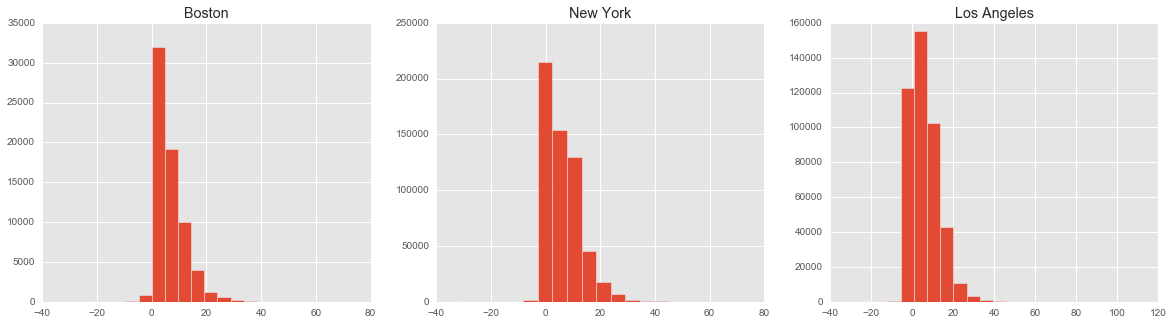

In [3]:
def get_sentiment_score(filelist): 
    output = []
    for filename in filelist:
        with open(filename, 'r') as f:
            lines = f.read()
            fields = lines.split(',')
            sum = 0
            print len(fields)
            for field in fields:
                sum += int(field)
            mean = sum * 1.0 / len(fields)
            sum = 0
            for field in fields:
                sum += (int(field) - mean) ** 2
            variance = sum * 1.0 / (len(fields) - 1)
            print filename, mean, variance
            output.append(fields)
    return output

filelist = ['bs_score.csv','ny_score.csv','la_score.csv']
output = get_sentiment_score(filelist)
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,3,1)
ax.hist(np.array(output[0]).astype(int),20)
plt.title('Boston')
ax = fig.add_subplot(1,3,2)
ax.hist(np.array(output[1]).astype(int),20)
plt.title('New York')
ax = fig.add_subplot(1,3,3)
ax.hist(np.array(output[2]).astype(int),20)
plt.title('Los Angeles')
plt.show()

For analysis, we conducted pair hypothesis test on the mean of sentiment score for three cities. 
Our analytical results are shown below: 

| City        | Mean       | Variance | Sample Size|
|-----------------------|-------------------------------------------|-------|---|
| Boston     |5.90180886122 | 37.6440771978 |68,275|
| Los Angeles     |6.38499456094 |43.0399002764|439,414|
| New York     |6.07569196401 |42.8396365636|574,777|

We take hypothesis using $\alpha=0.05$ and the analysis result are as follows:

<center>$H_0: \mu_{la} - \mu_{bs} \leq 0$. (LA has average sentiment score no higher than Boston)  
$H_1: \mu_{la} - \mu_{bs} > 0$. (LA has average sentiment score higher than Boston)  

<center>$z = \frac{x_{la} - x_{bs}}{\sqrt{\frac{\sigma_{la}^2}{n_{la}}+\frac{\sigma_{bs}^2}{n_{bs}}}}=3.057$  
p-value = 0.0022  
CI = $x_{la} - x_{bs} \pm z*\sqrt{\frac{\sigma_{la}^2}{n_{la}}+\frac{\sigma_{bs}^2}{n_{bs}}}=[0.2232, 0.7431]$ 

Reject H0, LA has higher average sentiment score than Boston, which also align with CI.

<center>$H_0: \mu_{ny} - \mu_{bs} \leq 0$. (New York has average sentiment score less or equal to Boston)  </center>
<center>$H_1: \mu_{ny} - \mu_{bs} > 0$. (New York has average sentiment score higher than Boston)</center>

<center>$z = \frac{x_{ny} - x_{bs}}{\sqrt{\frac{\sigma_{ny}^2}{n_{ny}}+\frac{\sigma_{bs}^2}{n_{bs}}}}=1.1240$  
p-value = 0.2610  
CI = $x_{ny} - x_{bs} \pm z*\sqrt{\frac{\sigma_{ny}^2}{n_{ny}}+\frac{\sigma_{bs}^2}{n_{bs}}}=[-0.0806, 0.4284]$ </center>

Accept H0, New York is less or equal to Boston, which align with the CI.

So we have got the order of sentiment score ranking: LA > Boston >= NYC, which indicates higher user experience in LA than in other two cities.


In [4]:
# reference : http://stats.stackexchange.com/questions/124096/two-samples-z-test-in-python
def twoSampZ(X1, X2, mudiff, sd1, sd2, n1, n2):
    from numpy import sqrt, abs, round
    from scipy.stats import norm
    pooledSE = sqrt(sd1**2/n1 + sd2**2/n2)
    z = ((X1 - X2) - mudiff)/pooledSE
    pval = 2*(norm.sf(abs(z)))
    CI = X1-X2-1.645*pooledSE,X1-X2+1.645*pooledSE
    print 'z_score, p-value, CI'
    return round(z, 3), round(pval, 4), CI

print 'LA vs BS'            
print twoSampZ(6.38499456094,5.90180886122,0,43.0399002764,37.6440771978,439414,68275)
print 'NY vs BS'
print twoSampZ(6.07569196401,5.90180886122,0,42.8396365636,37.6440771978,574777,68275)

LA vs BS
z_score, p-value, CI
(3.0579999999999998, 0.0022000000000000001, (0.22323867323007707, 0.74313272620992277))
NY vs BS
z_score, p-value, CI
(1.1240000000000001, 0.26119999999999999, (-0.080684960536245853, 0.42845116611624512))


### 4.2 Further Exploration Users Characteristics:
To find more about user experience in the three cities, we have elaborated our result using user data and further analysis on the users characteristics and behaviors in different cities and see how it might relates to the hypothesis result.

#### 4.2.1 Descriptive Stats Fact
Here is the dashboard of our exploration effort. We generated this dashboard with the help of [superset](https://github.com/airbnb/superset), a data exploration platform.

<img src="dashboard1.jpeg">
The fisrt image here has three parts. The one on the left shows the total amount of sample, which is 14.6k, and its trend through their account create time. The one in the middle shows the user quality grouped by three cities where we can see that LA has relatively higher quality users judged by average sentiment score in their reviews. The right one is the trend of user count spread in three cities where the year of 2015 has the largest amount of users no matter the desitination city is.
<img src="dashboard2.jpeg">
The second image is a bubble plot where x axis is sentiment score and y axis is the distance. From this, we can roughly see that most visitors in our sample are domestic travellers or people living in nearby cities and there are 4 groups distinguished by distance.
<img src="dashboard3.jpeg">
Next is travel distance distribution histogram. It is the evidence of our finding from the last picture where we say most users are from nearby cities.
<img src="dashboard4.jpeg">
We also plotted a bar chart to show the trend of user amount from different cities. The top 10 countries are Canada, United Kingdom, Germany, France, China, Australia, Netherlands, Italy, Switerland and Spain.
<img src="dashboard5.jpeg">
Then here is the user category in tourists among three cities. Students play the important part in all cities, and then teachers, retired and self-employed. What interesting is, photographers tend to prefer LA and NY while artists like LA the most.
<img src="dashboard6.jpeg">
This last picture is a world map of user origin where we can clearly see the user origin distribution.

In [169]:
boston = pd.read_csv('boston.csv', header=None, names=['from_country','visit_city','longitude','latitude','trips','work','school','total_fdbs','distance','about','create_time','sentiment_score'])
boston['create_time'] = pd.to_datetime(boston.create_time, coerce=True)
boston['time_of_usage'] = (pd.datetime.now().date() - boston.create_time).apply(lambda l:l.days)/365

la = pd.read_csv('la.csv',header=None, names = ['from_country','visit_city','longitude','latitude','trips','work','school','total_fdbs','distance','about','create_time','sentiment_score'])
la['create_time'] = pd.to_datetime(la.create_time, coerce=True)
la['time_of_usage'] = (pd.datetime.now().date() - la.create_time).apply(lambda l:l.days)/365

ny = pd.read_csv('newyork.csv',header=None, names = ['from_country','visit_city','longitude','latitude','trips','work','school','total_fdbs','distance','about','create_time','sentiment_score'])
ny['create_time'] = pd.to_datetime(ny.create_time, coerce=True)
ny['time_of_usage'] = (pd.datetime.now().date() - ny.create_time).apply(lambda l:l.days)/365


/anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead
  from ipykernel import kernelapp as app
/anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead
/anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead


#### Correlation exploration
The pair correlations analysis between numerical features of three cities.

In [207]:
#reference: https://www.kaggle.com/zoupet/d/arathee2/demonetization-in-india-twitter-data/wordcloud-time-series-cluster-modelisation/comments
def find_correlation(city, ax, title_graph):
    # Compute the correlation matrix
    corr = city[city.select_dtypes(exclude=['object']).columns.values].corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
#     f, ax = plt.subplots(figsize=(10, 4))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(920, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    ax.set_title(title_graph)

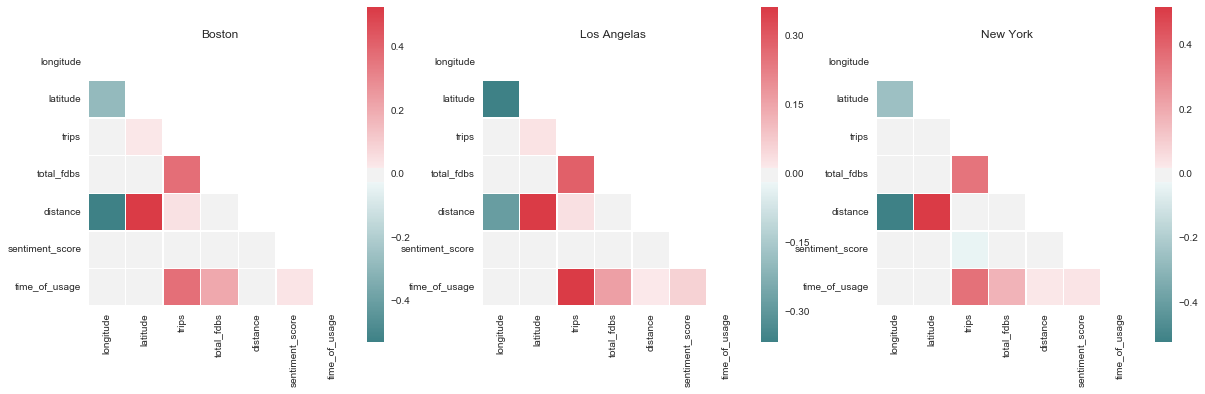

In [211]:
%matplotlib inline
plt.style.use("ggplot")
sns.set(style="white")
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
find_correlation(boston,ax1, 'Boston')
find_correlation(la,ax2, 'Los Angelas')
find_correlation(ny,ax3, 'New York')

#### Geographical characteristics
The graph shows where are the visitors come from, from the graph we can see most of the users are domestic visitors, and others are mostly comming from Europe.

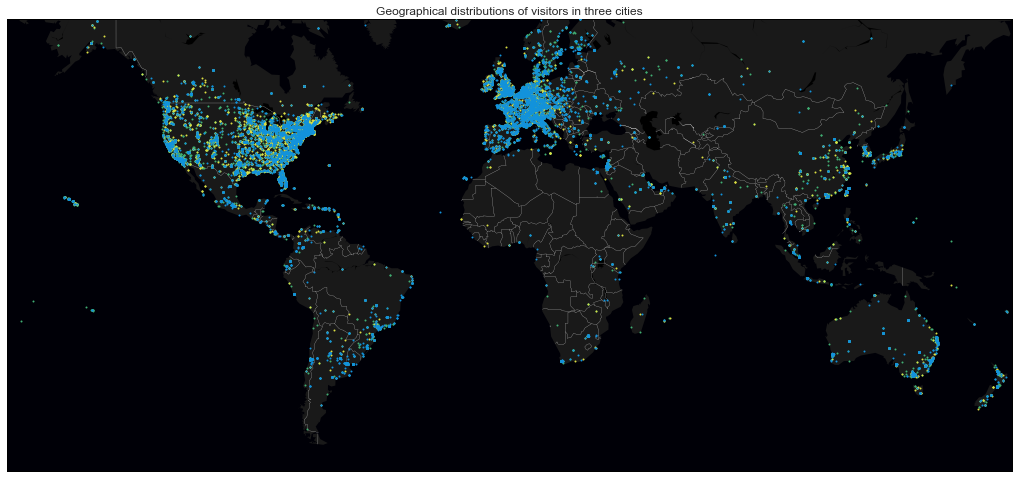

In [213]:
plt.figure(1, figsize=(18,9))
m = Basemap(projection='merc',
             llcrnrlat=-60,
             urcrnrlat=65,
             llcrnrlon=-180,
             urcrnrlon=180,
             lat_ts=0,
             resolution='c')
m.fillcontinents(color='#191919',lake_color='#000000')
m.drawmapboundary(fill_color='#000007') 
m.drawcountries(linewidth=0.2, color="w")

# Plot map
x1, y1 = m(la.latitude.tolist(),la.longitude.tolist())
x2, y2 = m(boston.latitude.tolist(),boston.longitude.tolist())
x3, y3 = m(ny.latitude.tolist(),ny.longitude.tolist())
m.scatter(x1,y1, s=4, c="#41AF73", lw=0, alpha=1, zorder=5)
m.scatter(x2,y2, s=4, c="#DBDF43", lw=0, alpha=1, zorder=5)
m.scatter(x3,y3, s=4, c="#1292db", lw=0, alpha=1, zorder=5)
plt.title('Geographical distributions of visitors in three cities')
plt.show()

#### Users' Education Level
As we can observe, about 50% users didn't provide any information about their education. For the rest half of users who provided information about their education, more than 70% users attended a college or university. Among visitors who have been to Los Angeles and Boston, 20% attended an unknown institution, probably a high school or other universities outside the U.S.(as we have a dictionary of all U.S. universities). The percentage in New York is much higher, which is 27.5%. It may indicate people who visited New York are more likely from other nations. We can also confirm that about 2% to 3% users attended a highschool. 

All in all, at least 35% of all Airbnb users have advanced education.This contributes to a civilized and cordial user society.

In [26]:
# Load user data
def load_csv(filename):
    df = pd.read_csv(filename, names=['from_country', 'visit_city', 'latitude', 'longtitude',
                                   '#trips', 'work', 'school', '#feedback', 'distance','about','create_time','sentiment_score'])
    return df

In [30]:
# A method used to verify whether a review contains non-English words
def is_not_english(s):
    try:
        s.decode('ascii')
    except UnicodeDecodeError:
        return True
    else:
        return False

# Iterate user data and find out their education level
def get_education_level(filename):
    df_school = load_csv(filename)
    df_school.school = df_school.school.fillna("na")
    with open('university_names.txt') as f:
        university_names = f.read().splitlines() 
    total = df_school.shape[0]
    [blank, college_level, highschool_level, undefined] = [0] * 4

    for column, row in df_school.iterrows():
        school = row['school'].lower()
        if school == 'na': 
            blank += 1 # N/A cells
        elif is_not_english(school): 
            undefined += 1 # Undefined schools that contains non-English words
        elif any(kind in school for kind in ['university','college']) or any(kind in school for kind in university_names):
            college_level += 1 # Contains words "university", "college" or ad-hoc names such as "cmu" or "uc-berkeley"
        elif any(kind in school for kind in ['highschool','high school']):
            highschool_level += 1 # Contains "highschool" or "high school" but not universities
        else:
            undefined += 1 # Other institutions that are not defined
            
    print "Without school information",blank,"/",total,"(",format(blank/float(total)*100, '.4f'),"%)"
    return total, blank, college_level, highschool_level, undefined

# Plot pie charts
def plot_data(filename):
    total, blank, college_level, highschool_level, undefined = get_education_level(filename)
    labels = 'College', 'Highschool', 'School Undefined'
    sizes = [college_level, highschool_level, undefined]
    colors = ['yellowgreen', 'gold', 'lightskyblue']
    p = plt.pie(sizes, colors=colors, startangle=180, autopct='%1.1f%%') # shadow=True
    return p

Without school information 19402 / 39594 ( 49.0024 %)
Without school information 13841 / 27518 ( 50.2980 %)
Without school information 14939 / 29750 ( 50.2151 %)


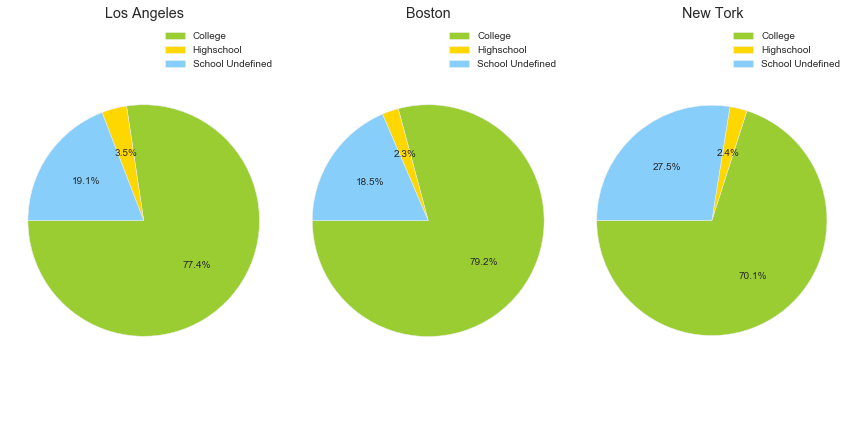

In [31]:
fig = plt.figure(figsize=(12, 6))
labels = ['College', 'Highschool', 'School Undefined']
plt.rc('lines', linewidth=2, color='r')

ax1 = fig.add_subplot(131)
ax1 = plot_data('la_raw.csv')
plt.axis('equal')
plt.title('Los Angeles')
plt.legend(labels, loc="best")

ax2 = fig.add_subplot(132)
ax2 = plot_data('bs_raw.csv')
plt.axis('equal')
plt.title('Boston')
plt.legend(labels, loc="best")

ax3 = fig.add_subplot(133)
ax3 = plot_data('ny_raw.csv')
plt.axis('equal')
plt.title('New Tork')
plt.legend(labels, loc="best")

plt.rc('lines', linewidth=0, color='r')
plt.tight_layout()
fig = plt.gcf()

#### Users' Job
From these three words cluster, we can observe that student is the largest visitor group to all three cities we are looking at. Teacher is the second largest group in both Boston and New York but this is not the case in Los Angeles, where manager takes place.Consultant, engineer, self-employed or freelance, and the retired are four major groups for all three cities. Boston attracts unique group of medical professionals and hospital employees while New York and Los Angeles are favored by artists and designers.   

In [34]:
# Concatenate all words from "work" column of users
def get_words(filename):
    df = load_csv(filename)
    df.work = df.work.fillna('na')
    all_words = []
    for column, row in df.iterrows():
        job = row['work'].lower()
        if job == 'na':
            continue
        else:
            all_words.append(job)
    return " ".join(all_words)

# Generate a wordcloud for job titles
def create_wordcloud_education_level(filename,title):
    words = get_words(filename)
    stopwords = set(STOPWORDS)
    stopwords.add(title.lower())
    stopwords.add("hidden")
    stopwords.add("university")
    stopwords.add("college")
    stopwords.add("url")
    stopwords.add("group")
    stopwords.add("inc")
    stopwords.add("company")
    stopwords.add("de")
    stopwords.add("us")
    stopwords.add("center")
    stopwords.add("school")    
    wordcloud = WordCloud(background_color="white", stopwords=stopwords, random_state=2016, max_words=12).generate(words)
    return wordcloud

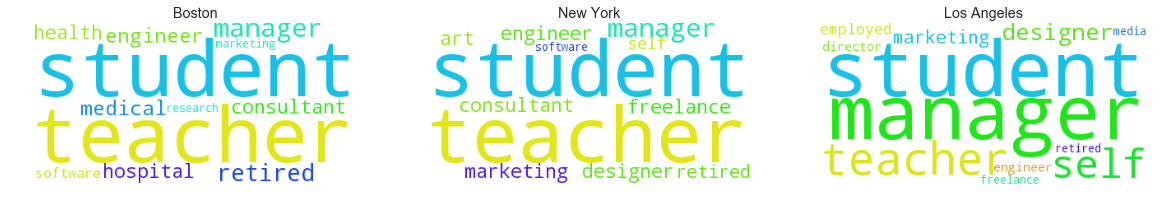

In [35]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(1,3,1)
ax.imshow(create_wordcloud_education_level('bs_raw.csv','Boston'))
ax.axis('off')
plt.title('Boston')
ax = fig.add_subplot(1,3,2)
ax.imshow(create_wordcloud_education_level('ny_raw.csv','New York'))
ax.axis('off')
plt.title('New York')
ax = fig.add_subplot(1,3,3)
ax.imshow(create_wordcloud_education_level('la_raw.csv','Los Angeles'))
plt.title('Los Angeles')
ax.axis('off')
plt.show()

#### 4.2.2. Kmeans Clustering similar visitors group 
So is there any similarity or difference of visitor groups imbeded for different cities? To answer this, we used kmeans on four dimensions: number of trips visitors had, distance from home to traveled city, user quality (reflected by the sentiment score of comments other people had for this user), years of usage (time elapsed from created till now) and implemented four clusters kmeans training on three cities. We found that NY and Boston clusters are similar, however they are different from LA. This leads us to the conclusion that visitors' characteristics seem more similar in cities near to each other. When visitors went to Boston, there is also a high chance that they will go to New York.

In [219]:
# reference: http://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html

def plotKmeans(df, index,fig,title):
    def findClusters(df, label):
        return df[df['labels']==label].index
    ax = fig.add_subplot(1,3,index)
    new_df = df.copy()
    new_df = new_df.drop(['from_country','visit_city','longitude','latitude','work','school','total_fdbs','create_time','about'], axis=1)
    k_means = KMeans(init='k-means++',n_clusters=4).fit(new_df)
    colors = ['#4EACC5', '#FF9C34', '#4E9A06','#41AF73']
    fig = plt.figure()
    k_means_cluster_centers = np.sort(k_means.cluster_centers_, axis=0)
    k_means_labels = pairwise_distances_argmin(new_df, k_means_cluster_centers)
    new_df['labels'] = k_means_labels
    
    dt = {}
    for i in range(4):
        dt[i] = findClusters(new_df, i).tolist()

    color = ['pink', 'purple','grey', 'c']
    color2 = ['black', 'black','black', 'black']
    for i in xrange(4):
        x = []
        y = []
        for ids in dt[i]:
            x.append(new_df.iloc[ids][1])
            y.append(new_df.iloc[ids][2])
        ax.plot(x, y, color = color[i], marker = '*', ls='None')
        ax.plot([k_means_cluster_centers[i][1]], [k_means_cluster_centers[i][2]], color = color2[i], marker = 'o', ls = 'None')
        ax.set_title(title)
    

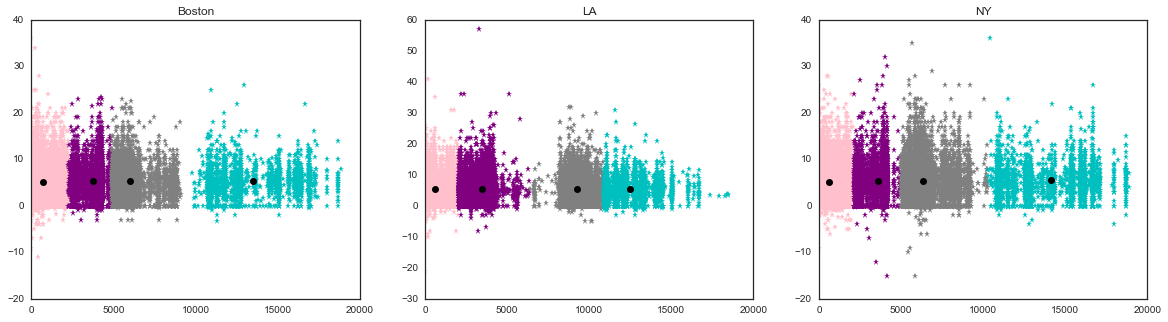

In [220]:

fig = plt.figure(figsize=(20,5))
plotKmeans(boston,1,fig,'Boston')
plotKmeans(la, 2, fig,'LA')
plotKmeans(ny, 3, fig,'NY')

### 5. Findings and Conclusions.

1. LA has a higher positive rate regarding user experience compared with another two cities.
2. Room cleanliness and location has relatively greater effect on users' experience in all cities.
3. Visitors in LA prefer to book houses while visitors in Boston and New York have a higher preference for appartment. This might due to the higher price for houses in New York and Boston. LA, where land price and population density are lower, has more houses available all around the city while New York and Boston have much fewer houses but more apartments, especially near the city center, leading to a much higher price for hourses over apartments. Student is the largest visior group in Airbnb and they are more likely to choose a cheaper option. The result of our research reflects their decision well. 
4. Some places with local characteristics can be seen through NYC and LA, e.g. NYC seem noted for its subway and Manhattan district, LA is noted for its beach. However, for Boston, not much significant places with local characteristics mentioned in the reviews.
5. Nearby cities attract visitors with more similar characteristics, from kmeans analysis result, Boston and New York visitors clusters are similar but different from LA's.
6. For users whose education information is available, the education level is high. More than 70% of these users have attended a college.
7. People with different job titles may prefer different cities. Student is the largest visior group in all three cities. Teachers, managers, consultant, engineer, self-employed, and the retire are also important groups in these cities. There are also differences, such as medical professionals and hospital employees for Boston and artists and designers for New York and Los Angeles.

#### Reference

1.[data source](https://www.airbnb.com/)  
2.[Superset](http://airbnb.io/superset/installation.html)  
3.[z-test formula](http://stats.stackexchange.com/questions/124096/two-samples-z-test-in-python)  
4.[correlation finding](https://www.kaggle.com/zoupet/d/arathee2/demonetization-in-india-twitter-data/wordcloud-time-series-cluster-modelisation/comments)  
5.[kmeans](http://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html)  
6.All imported libraries documentation  